## Run the sections A, B, C, D, E, F, G, H sequentially. Then the main program is ready to run and conduct experiment.

## (A) The First 2 bunch of codes are to initialize the motion controller ESP 300

In [ ]:
from pymeasure.instruments.newport import ESP300
from pymeasure.instruments import list_resources

from pymeasure.display import widgets as pw
from pymeasure.display.inputs import *

import ftd2xx  # Thorlabs MFF101
import ftd2xx.defines as constants
from ftd2xx import listDevices, getDeviceInfoDetail

import pymeasure.experiment.parameters as pars

from time import sleep
from pymeasure.experiment import Procedure
from pymeasure.experiment import IntegerParameter



## (B)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## (C) The next bunch of code should be run to initialize the Spectrometer (PrincetonInstruments Lightfield Software) 

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import clr
import sys
import os
from System.IO import *
from System import String
from System.Threading import AutoResetEvent
from System.Collections.Generic import List

# Add needed dll references
sys.path.append(os.environ['LIGHTFIELD_ROOT'])
sys.path.append(os.environ['LIGHTFIELD_ROOT']+"\\AddInViews")
clr.AddReference('PrincetonInstruments.LightFieldViewV5')
clr.AddReference('PrincetonInstruments.LightField.AutomationV5')
clr.AddReference('PrincetonInstruments.LightFieldAddInSupportServices')

# PI imports
from PrincetonInstruments.LightField.Automation import Automation
from PrincetonInstruments.LightField.AddIns import CameraSettings
from PrincetonInstruments.LightField.AddIns import ExperimentSettings
from PrincetonInstruments.LightField.AddIns import DeviceType
from PrincetonInstruments.LightField.AddIns import SpectrometerSettings

        
def save_file(filename):    
    # Set the base file name
    experiment.SetValue(
        ExperimentSettings.FileNameGenerationBaseFileName,
        Path.GetFileName(filename))
    
    # Option to Increment, set to false will not increment
    experiment.SetValue(
        ExperimentSettings.FileNameGenerationAttachIncrement,
        True)

    # Option to add date
    experiment.SetValue(
        ExperimentSettings.FileNameGenerationAttachDate,
        True)

    # Option to add time
    experiment.SetValue(
        ExperimentSettings.FileNameGenerationAttachTime,
        True)

def device_found():
    # Find connected device
    for device in experiment.ExperimentDevices:
        if (device.Type == DeviceType.Camera):
            return True
     
    # If connected device is not a camera inform the user
    print("Camera not found. Please add a camera and try again.")
    return False  



# Create the LightField Application (true for visible)
# The 2nd parameter forces LF to load with no experiment 
auto = Automation(True, List[String]())
application= auto.LightFieldApplication
experiment = auto.LightFieldApplication.Experiment
file_manager=application.FileManager


# (D) Establish connection with the ESP300 and Flipper Mirror

In [ ]:
# from pymeasure.instruments.lighthousephotonics import Sprout
# laser = Sprout('COM1')
# laser.adapter.connection.baud_rate = 19200
# laser.adapter.connection.read_termination = '\r'
# laser.adapter.connection.write_termination = '\r'

ser = b'37000805'  # flipper
ctrl = ESP300("GPIB0::3::INSTR")


ctrl.data_bits=8
ctrl.baud_rate=19200
ctrl.StopBits=1
ctrl.read_termination='\r\n'
ctrl.write_termination='\r'

# (E) Record the position of the x,y,z axes of the motion controller

In [ ]:
x = ctrl.x  # Our x-axis is motor 1 or y
y = ctrl.y  # Our y-axis is motor 2 or x
z = ctrl.phi  # 3
pos = [x.position, y.position, z.position]
print(pos)
print(x.enabled,y.enabled,z.enabled)





## (F) Import the flipper mirror and Laser Power controlling package**

In [ ]:
from flipper import mirror
#mirror('off')
from pymeasure.instruments.lighthousephotonics import Sprout
laser_power = Sprout('COM1')
laser_power.adapter.connection.baud_rate = 19200
laser_power.adapter.connection.read_termination = '\r'
laser_power.adapter.connection.write_termination = '\r'
laser_power.power=0.01

## Main Program to begin the experiment
**Here the main experiment begins**

Initializing starts

{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}

Patterning will be started within 10 seconds


Patterning Starts

{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[221. 206. 206. ... 244. 205. 217.]
 [216. 211. 215. ... 211. 219. 222.]
 [206. 209. 209. ... 220. 208. 210.]
 [204. 205. 203. ... 219. 207. 221.]
 [205. 210. 203. ... 208. 207. 228.]]
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[217. 209. 215. ... 212. 204. 214.]
 [205. 212. 216. ... 203. 194. 211.]
 [215. 206. 195. ... 200. 199. 207.]
 [212. 212. 204. ... 200. 216. 19

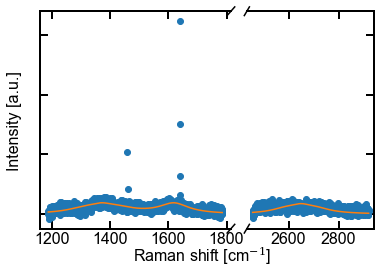

C:\Users\labuser\Anaconda3\lib\site-packages\ipykernel_launcher.py:231: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


None
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[206. 195. 209. ... 205. 217. 217.]
 [205. 204. 202. ... 203. 200. 209.]
 [201. 196. 190. ... 204. 191. 197.]
 [199. 204. 215. ... 197. 208. 209.]
 [190. 197. 196. ... 202. 198. 190.]]
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[201. 200. 210. ... 184. 189. 201.]
 [200. 193. 198. ... 201. 187. 196.]
 [202. 199. 194. ... 179. 186. 198.]
 [203. 206. 196. ... 195. 188. 202.]
 [199. 204. 199. ... 196. 195. 185.]]


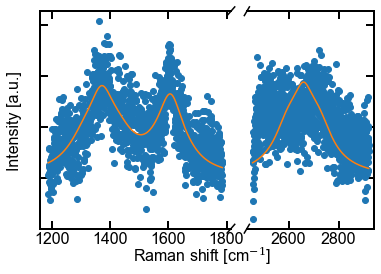

None
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[205. 202. 196. ... 203. 197. 211.]
 [183. 192. 189. ... 196. 196. 207.]
 [207. 208. 192. ... 197. 186. 215.]
 [194. 197. 197. ... 208. 196. 200.]
 [201. 194. 188. ... 207. 187. 198.]]
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[188. 185. 196. ... 184. 197. 194.]
 [204. 178. 195. ... 182. 197. 189.]
 [203. 200. 181. ... 180. 189. 196.]
 [205. 197. 193. ... 190. 181. 195.]
 [202. 195. 189. ... 200. 181. 193.]]


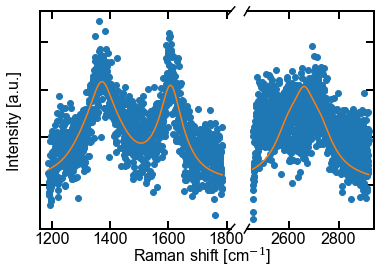

None
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[204. 191. 189. ... 206. 200. 224.]
 [199. 186. 197. ... 197. 200. 192.]
 [195. 201. 215. ... 188. 189. 203.]
 [193. 191. 188. ... 202. 188. 194.]
 [186. 186. 200. ... 194. 196. 193.]]
Experiment Completed

Found the .spe file...
Image saved to C:\Users\labuser\Desktop\data\Raman\Vivek\2019-10-08
[[202. 191. 196. ... 181. 179. 190.]
 [192. 196. 204. ... 185. 187. 191.]
 [204. 198. 199. ... 181. 178. 189.]
 [180. 203. 189. ... 183. 182. 186.]
 [201. 206. 209. ... 179. 187. 195.]]


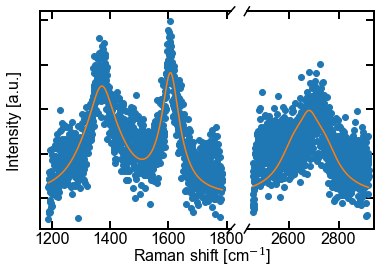

None
{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}


In [82]:
from __future__ import division
import pandas as pd

import time
import os
os.chdir("C:\\Users\\labuser")
df=pd.read_csv("dataset-2.csv")
df.head()
power_of_file=df["power"]
time_of_file=df["time"]

#initialize position
print("Initializing starts\n")
x.position=4
y.position=5
# z.position=3.25


mirror('off') #make sure mirror is off
laser_power.power=0.01   #make sure laser power is down to 0.01 W
print("\nPatterning will be started within 10 seconds\n")
time.sleep(10)





print("\nPatterning Starts\n")
#position=[[2,4],[2,3],[3,4],[3,3]]
position=[[4,5],[5,5],[6,5],[7,5]]
for i in range(4):
    if i>=2:
        import rpy2.robjects as robjects
        robjects.r('''
        suppressWarnings({suppressMessages({
          library(mlrMBO)
          library(ggplot2)
        })})

        ps = makeParamSet(
          makeIntegerParam("power", lower = 10, upper = 2200),
          makeIntegerParam("time", lower = 500, upper = 2000),
          makeDiscreteParam("gas", values = c("Argon")),
          makeIntegerParam("pressure", lower = 920, upper = 930)
        )

        ctrl = makeMBOControl(y.name = "ratio")
        ctrl = setMBOControlInfill(ctrl, opt = "focussearch", opt.focussearch.maxit = 10, opt.focussearch.points = 10000, crit = makeMBOInfillCritEI())

        data=read.csv("dataset-2.csv")
        data<-na.omit(data)
        suppressMessages({opt.state = initSMBO(par.set = ps, design = data, control = ctrl, minimize = FALSE, noisy = TRUE)})
        print("Proposed parameters:")
        prop = suppressWarnings({proposePoints(opt.state)})
        print(prop$prop.points)
        x<-prop$prop.points
        write.table(x, file = "dataset-2.csv", sep = ",", append = TRUE, quote = FALSE,col.names = FALSE, row.names = FALSE)
        ''')
        
        
    df=pd.read_csv("dataset-2.csv")
    power_of_file=df["power"]
    time_of_file=df["time"]

    x.position=position[i][0]
    y.position=position[i][1]
    time.sleep(10)
    a=power_of_file[i]
#     b=float(a/1e3)
#     laser_power.power=b
    laser_power.power=((a-2.7979)/0.4639)/1000
    time.sleep(10)
    mirror('on') #irradiation begins
    
    
    t=time_of_file[i] 
    laser_time=float(t/1e3)
    time.sleep(laser_time+1) #exposure time
    
    mirror('off')
    time.sleep(5)
    laser_power.power=0.01
    time.sleep(4)
    
    #begin capturing spectra
    mirror("on")
    capture_photo("on",i)
    mirror("off")
    time.sleep(5)
    
    
        

## (G)
**The following capture_photo function is called from the main program to power the spectrometer camera, capture the photos for raman analysis.**


**After capturing 2 foreground pictures at wavenumber 1500 and 2700, 2 corresponding .spe files are saved. After reading them 2 different csv files are saved recording the wavelength and intensity data**

**The csv files are further sent into ration function, where some fittings are done, G/D ratio is measured and some other properties as well**


In [48]:
def capture_photo(begin,exp_no):
    if begin=="on":
        def set_value(setting, value):    
        # Check for existence before setting
        # gain, adc rate, or adc quality
            if experiment.Exists(setting):
                experiment.SetValue(setting, value)

        def experiment_completed(sender, event_args):    
            print("Experiment Completed")    
            # Sets the state of the event to signaled,
            # allowing one or more waiting threads to proceed.
            acquireCompleted.Set()

        import time

        # Check for device and inform user if one is needed
        if (device_found()==True): 
            experiment.ExperimentCompleted += experiment_completed 
            # Check this location for saved spe after running
            #print("Please Enter the Exposure Time:\n")
            #x=int(input())
            set_value(CameraSettings.ShutterTimingExposureTime,3000)
            #print("Please Enter the Number of Frames")
            #y=int(input())
            experiment.SetValue(ExperimentSettings.AcquisitionFramesToStore,5)
            for k in range(1,3):
                if k==1:
                    experiment.SetValue(SpectrometerSettings.GratingCenterWavelength,578.1351880026082)
                elif k==2:
                    experiment.SetValue(SpectrometerSettings.GratingCenterWavelength,621.2340604418703)
                _file_name = "case"

                # Pass location of saved file
                save_file(_file_name)

                # Acquire image
                experiment.Acquire()
                time.sleep(35)
                directory="C:\\Users\\labuser\\Desktop\\data\\Raman\\Vivek\\2019-10-08"
                if( os.path.exists(directory)):        
                        print("\nFound the .spe file...")        

                        # Returns all .spe files
                        files = glob.glob(directory +'/*.spe')

                        # Returns recently acquired .spe file
                        last_image_acquired = max(files, key=os.path.getctime)

                        try:
                            # Open file
                            file_name = file_manager.OpenFile(
                                last_image_acquired, FileAccess.Read)

                            # Access image
                            file=file_name
                            imageData = file.GetFrame(0,0)
                            #here is a problem 11-18-2019
                            n=5
                            intensity_frame=np.zeros((n,1340))
                            # Get image data
                            buffer = imageData.GetData()
                            #buffer=imageData.GetDataBuffer()
                            # Print first 10 pixel intensities
                            for i in range(0,n):
                                imageData=file.GetFrame(0,i)
                                buffer=imageData.GetData()
                                for pixel in range(0,1340):
                                    intensity_frame[i][pixel]=buffer[pixel]

                            file_name.Dispose()


                        except IOError:
                            print ("Error: can not find file or read data")

                else:
                    print(".spe file not found...")

                print(String.Format("{0} {1}",
                                    "Image saved to",
                                    experiment.GetValue(
                                        ExperimentSettings.
                                        FileNameGenerationDirectory)))  


                wl= experiment.SystemColumnCalibration
                wavelength=np.zeros((1,1340))
                for i in range(1340):wavelength[0,i]=wl[i]
                #print(intensity_frame)
                intensity=np.zeros((1,1340))
                for i in range(1340):
                    x=0
                    for j in range(n):
                        x=x+intensity_frame[j][i]
                    x=x/n
                    intensity[0,i]=x
                    check_intensity=x

                w=[]
                inten=[]

                for x in range(1340):
                    wavelength[0,x]=1e7*(1/532 - 1/wavelength[0,x])
                    w.append(wavelength[0,x])
                    inten.append(intensity[0,x])
                import csv
          
                m="foreground"+str(k)+"D.csv"
                with open(m, 'w', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow(["W", "I"])
                    writer.writerows(zip(w,inten))
        m1="foreground1D.csv"
        m2="foreground2D.csv"
        if check_intensity>=40e3:
            print("experiment: ",exp_no, ":Patterning not done")
            
        elif check_intensity<40e3:
            print(ration(m1,m2,exp_no)) 
        

## (H)
**The following codes and ration function is to fit the data of aforementioned csv files named foreground1.csv and foreground2.csv . This function estimated G/D ration, the ratio peaks, the width of those regions and their index values as well.**

In [46]:
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%pylab inline

import sys
import pandas as pd # python data manipulation and analysis library
import numpy as np #  Library with large collection of high-level mathematical functions to operate on arrays
import matplotlib.pyplot as plt #python plotting library
import peakutils #baselining library

import os,glob
 # Library with operating system dependent functionality. Example: Reading data from files on the computer

from sklearn import preprocessing
    
import csv
from lmfit import Parameters, minimize, report_fit



# bg1 = max(glob.glob('*1500wavenumber.csv'), key=os.path.getctime)  # bg_G
# fn1 = max(glob.glob('*GD.csv'), key=os.path.getctime)  # fn_G

# bg2 = max(glob.glob('*2700wavenumber.csv'), key=os.path.getctime)  # bg_2D
# fn2 = max(glob.glob('*_2D.csv'), key=os.path.getctime)  # fn_2D
def ration(m1,m2,counter):
    bg1 = pd.read_csv("background1D.csv")  # bg_G
    fn1 = pd.read_csv("foreground1D.csv")  # fn_G

    bg2 = pd.read_csv("background2D.csv")  # bg_2D
    fn2 = pd.read_csv("foreground2D.csv")  # fn_2D

    # d1 = pd.read_csv(fn1)
    # d1_ = pd.read_csv(bg1)
    d1=fn1
    d1_=bg1
    d1['I']=d1['I']-d1_['I']
    base1 = peakutils.baseline(d1['I'], 1)
    d1['I_base']= d1['I']-base1

    # d2 = pd.read_csv(fn2)
    # d2_ = pd.read_csv(bg2)
    d2=fn2
    d2_=bg2
    d2['I']=d2['I']-d2_['I']
    base2 = peakutils.baseline(d2['I'], 1)
    d2['I_base']= d2['I']-base2



    standardFonts = {'family' : 'Arial',
                     'size' : 14}

    subplotLabels = {'fontweight' : 'bold',
                     'verticalalignment': 'baseline',
                     'horizontalalignment': 'left'}

    matplotlib.rc('font', **standardFonts)
    mpl.rcParams['mathtext.fontset']  = 'dejavuserif'
    mpl.rcParams['font.family']       = 'Arial'
    matplotlib.rc('font', **standardFonts)

    mpl.rcParams['xtick.major.size']  = 8
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['xtick.minor.size']  = 4
    mpl.rcParams['xtick.minor.width'] = 2
    mpl.rcParams['xtick.direction']   = 'in'
    mpl.rcParams['xtick.top']         = True
    mpl.rcParams['xtick.bottom']      = True
    mpl.rcParams['xtick.labelsize']   = 16
    mpl.rcParams['ytick.major.size']  = 8
    mpl.rcParams['ytick.major.width'] = 2
    mpl.rcParams['ytick.minor.size']  = 4
    mpl.rcParams['ytick.minor.width'] = 2
    mpl.rcParams['ytick.direction']   = 'in'
    mpl.rcParams['ytick.left']        = True
    mpl.rcParams['ytick.right']       = True
    mpl.rcParams['ytick.labelsize']   = 16

    mpl.rcParams['axes.linewidth']    = 2
    mpl.rcParams['axes.titlesize']    = 20
    mpl.rcParams['axes.titleweight']  = 'bold'
    mpl.rcParams['axes.labelweight']  = 'bold'
    mpl.rcParams['axes.labelsize']    = 16



    def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
        SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
        LorentzPart = Amp * (GammaL**2 / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
        GaussPart = Amp * np.exp( -((WavNr - Pos)/SigmaG)**2) # Gaussian distribution
        Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
        return Fit

    def one_pv(pars, x, data=None, eps=None): #Function definition
        # unpack parameters, extract .value attribute for each parameter
        a3 = pars['a3'].value
        c3 = pars['c3'].value
        s3 = pars['s3'].value
        f3 = pars['f3'].value

    #     background = line(x, m, c)
        peak1 = PseudoVoigtFunction(x.astype(float),c3, a3, s3, f3)
    #     peak2 = PseudoVoigtFunction(x.astype(float),c2, a2, s2, f2)

        model =  peak1  # The global model is the sum of the Gaussian peaks

        if data is None: # if we don't have data, the function only returns the direct calculation
            return model, peak1
        if eps is None: # without errors, no ponderation
            return (model - data)
        return (model - data)/eps # with errors, the difference is ponderated

    def two_pv(pars, x, data=None, eps=None): #Function definition
        # unpack parameters, extract .value attribute for each parameter
        a1 = pars['a1'].value
        c1 = pars['c1'].value
        s1 = pars['s1'].value
        f1 = pars['f1'].value


        a2 = pars['a2'].value
        c2 = pars['c2'].value
        s2 = pars['s2'].value
        f2 = pars['f2'].value


    #     m = pars['m'].value
    #     c = pars['c'].value

    #     background = line(x, m, c)
        peak1 = PseudoVoigtFunction(x.astype(float),c1, a1, s1, f1)
        peak2 = PseudoVoigtFunction(x.astype(float),c2, a2, s2, f2)

        model =  peak1 + peak2  # The global model is the sum of the Gaussian peaks

        if data is None: # if we don't have data, the function only returns the direct calculation
            return model, peak1, peak2
        if eps is None: # without errors, no ponderation
            return (model - data)
        return (model - data)/eps # with errors, the difference is ponderated



    ps1 = Parameters()

    #            (Name,  Value,  Vary,   Min,  Max,  Expr)
    ps1.add_many(('a1',    1 ,   True,     0, None,  None),
                 ('c1',   1350,   True,  1330, 1370,  None),
                 ('s1',     20,   True,    10,   60,  None),
                 ('f1',    0.5,   True,  None, 2,  None),
                 ('a2',      1,   True,     0, None,  None),
                 ('c2',    1600,   True, 1560,  1640,  None),
                 ('s2',     20,   True,    10,   60,  None),
                 ('f2',    0.5,   True,  None, 2,  None))
    #              ('m',       0,   True,   None,  None,  None),
    #              ('c',       0,   True,   None,  None,  None))

    # pars['f1'].vary = True
    # pars['f2'].vary = True

    ps2 = Parameters()

    #            (Name,  Value,  Vary,   Min,  Max,  Expr)
    ps2.add_many(('a3',      1,   True,     0, None,  None),
                 ('c3',    2700,   True, 2650,  2750,  None),
                 ('s3',     20,   True,    10,   60,  None),
                 ('f3',    0.5,   True,  None, 2,  None))
    #              ('m',       0,   True,   None,  None,  None),
    #              ('c',       0,   True,   None,  None,  None))

    # pars['f1'].vary = True
    # pars['f2'].vary = True

    x = d1['W']
    y = d1['I_base']
    out = minimize(two_pv, ps1, method = 'leastsq', args=(x, y))
    df1 = pd.DataFrame({key: [par.value] for key, par in out.params.items()})
    # guess = [1350, 100, 50, 1580, 300, 25]
    # pfit,perr = curve_fit(func,x,d1.iloc[:,111],p0=guess)

    x2 = d2['W']
    y2 = d2['I_base']
    out2 = minimize(one_pv, ps2, method = 'leastsq', args=(x2, y2))
    df2 = pd.DataFrame({key: [par.value] for key, par in out2.params.items()})
    df = pd.concat([df1,df2],axis=1)

    f, (ax,ax2)=plt.subplots(1,2,sharey=True, gridspec_kw = {'width_ratios':[1.5, 1]})
    f.subplots_adjust(wspace=0.1)

    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax2.xaxis.set_major_locator(MultipleLocator(200))

    ax.set_yticklabels([])

    ax.plot(x,y,'o',label='measured',)
    ax.plot(x,two_pv(out.params, x)[0],label='fit')
    ax2.plot(x2,y2,'o')
    ax2.plot(x2,one_pv(out2.params, x2)[0])

    f.text(0.05, 0.5, 'Intensity [a.u.]', va='center', rotation='vertical', fontsize=16)
    f.text(0.5, 0.01, 'Raman shift [cm$^{-1}$]', ha='center', rotation='horizontal',fontsize=16)

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    # ax.tick_params(labelright='off')  # don't put tick labels at the top
    ax2.yaxis.tick_right()
    # ax.yaxis.label('test')

    d = .02  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, + d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((- d, + d), (- d, + d), **kwargs)  # bottom-left diagonal
    ax2.plot((- d, + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # ax.legend(loc='upper right')
    # plt.savefig(p/'Raman_raw_111.png', format='png', dpi=300)
    plt.show()
    df.columns= ['D','PD','WD','FD','G','PG','WG','FG','2D','P2D','W2D','F2D']
    df['GD']=df['G']/df['D']
    df['2DG']=df['2D']/df['G']
    
    ml_file = pd.read_csv("dataset-2.csv")
    ml_file.set_value(counter, "ratio", df['GD'])
    ml_file.to_csv("dataset-2.csv", index=False)
    
#     for i in range(3):
#         if i==0:
#             df.to_csv("fit.csv", mode='a',encoding='utf-8')
#         else:df.to_csv("fit.csv", mode='a',encoding='utf-8',header=False)
            

    
    df.to_csv("fit.csv", mode='a',encoding='utf-8',header=False)
   






Populating the interactive namespace from numpy and matplotlib


**The following codes are some random stuff**

In [ ]:
# import matplotlib.pyplot as plt
# os.chdir("C:\\Users\\labuser\\Experiment1")
# bgr = pd.read_csv('back.csv', header = 0, index_col = 0, names = ['W', 'I'])
# plt.plot(bgr)
# plt.show()
from __future__ import division
import pandas as pd

import os
os.chdir("C:\\Users\\labuser")
df=pd.read_csv("dataset-2.csv")
df.head()
power_of_file=df["Power"]
time_of_file=df["Time"]


import time
x.position=9
y.position=4
time.sleep(8)

a=power_of_file[0]
b=float(a/1e3)
laser_power.power=b
time.sleep(10)
mirror('on') #irradiation begins


t=time_of_file[0] 
laser_time=float(t/1e3)
time.sleep(laser_time+1) #exposure time

mirror('off')
time.sleep(5)
laser_power.power=0.01
time.sleep(4)

In [85]:
x.position=4
y.position=4
z.position=3.25

In [68]:
mirror("off")


{'type': 5, 'id': 67369712, 'description': b'APT Filter Flipper', 'serial': b'37000805'}
1.8 0.0 -0.002151110153050226


In [87]:
print("Initial Positions:",pos,"\n")

import time
positions_dummy=[[5,4],[5,5],[5,6]]

for i in range(3):
    x.position=position[i][0]
    y.position=position[i][1]
    pos = [x.position, y.position, z.position]

    print(pos[0],pos[1],"\n")
    time.sleep(15)
    
print("Done")

Initial Positions: [4, 3.99999, 3.24999] 

4 4.99999 

5 4.99999 

6 4.99999 

Done


In [89]:
pos = [x.position, y.position, z.position]

print(pos[0],pos[1],"\n")

6 0.0 

